# Exemplo MNIST
[Script baseado nesse exemplo](https://github.com/awslabs/amazon-sagemaker-examples/tree/master/sagemaker-experiments/mnist-handwritten-digits-classification-experiment)

Pontos:
1. [Treinamento e inferência com scripts](#scripts)
2. [ML Pipeline](#pipeline)

<a id='scripts'/>

## 1. Treinamento e inferência com scripts


In [2]:
import sys

In [2]:
!{sys.executable} -m pip install sagemaker-experiments

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p36/bin/python -m pip install --upgrade pip' command.


### Install PyTorch

In [3]:
!{sys.executable} -m pip install torch
!{sys.executable} -m pip install torchvision

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p36/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p36/bin/python -m pip install --upgrade pip' command.


### Setup

In [4]:
import time

import boto3
import numpy as np
import pandas as pd
%config InlineBackend.figure_format = 'retina'
from matplotlib import pyplot as plt
from torchvision import datasets, transforms

import sagemaker
from sagemaker import get_execution_role
from sagemaker.session import Session
from sagemaker.analytics import ExperimentAnalytics

from smexperiments.experiment import Experiment
from smexperiments.trial import Trial
from smexperiments.trial_component import TrialComponent
from smexperiments.tracker import Tracker

In [5]:
sess = boto3.Session()
sm = sess.client('sagemaker')
role = get_execution_role()

### Bucket S3 para dados

In [6]:
# create a s3 bucket to hold data, note that your account might already created a bucket with the same name
account_id = sess.client('sts').get_caller_identity()["Account"]
bucket = 'sagemaker-experiments-{}-{}'.format(sess.region_name, account_id)
prefix = 'mnist'

try:
    if sess.region_name == "us-east-1":
        sess.client('s3').create_bucket(Bucket=bucket)
    else:
        sess.client('s3').create_bucket(Bucket=bucket, 
                                        CreateBucketConfiguration={'LocationConstraint': sess.region_name})
except Exception as e:
    print(e)

### Dataset

In [7]:
# download the dataset
# this will not only download data to ./mnist folder, but also load and transform (normalize) them
train_set = datasets.MNIST('mnist', train=True, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))]), 
    download=True)
                           
test_set = datasets.MNIST('mnist', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))]),
    download=False)

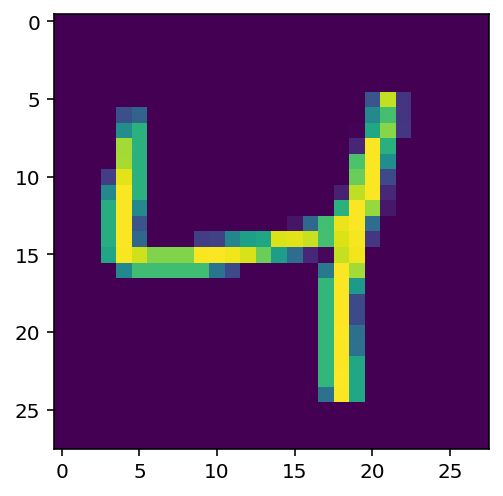

In [8]:
plt.imshow(train_set.data[2].numpy())

Upload para S3

In [9]:
inputs = sagemaker.Session().upload_data(path='mnist', bucket=bucket, key_prefix=prefix)
print('input spec: {}'.format(inputs))

input spec: s3://sagemaker-experiments-us-east-1-725879053979/mnist


### Treinando modelo pela primeira vez
Observar que script é salvo no S3 apenas após fazermos `estimator.fit(...)`.

Se quisermos customizar onde queremos salvar script no S3, basta setar no estimator o 
[`code_location`](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html#sagemaker.estimator.Framework)

Nas linhas de log dentro desse notebook podemos ver onde no S3 salvamos script:

``` 
(...)
Training Env:

{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        "training": "/opt/ml/input/data/training"
    
    ( . . . )
    
    "module_dir": "s3://sagemaker-us-east-1-725879053979/cnn-training-job-FIXED/source/sourcedir.tar.gz",
    "module_name": "mnist",
    
    ( . . . )
    
    "user_entry_point": "mnist.py"
    
    ( . . . )
}
(...)
```

In [10]:
from sagemaker.pytorch import PyTorch, PyTorchModel

In [11]:
# teste com Regex
estimator = PyTorch(
        entry_point='./mnist.py',
        role=role,
        sagemaker_session=sagemaker.Session(sagemaker_client=sm),
        framework_version='1.1.0',
        train_instance_count=1,
        train_instance_type='ml.c4.xlarge',
        hyperparameters={
            'epochs': 2,
            'backend': 'gloo',
            'hidden_channels': 10,
            'dropout': 0.2,
            'kernel_size': 5,
            'optimizer': 'sgd'
        },
        metric_definitions=[
            {'Name':'train:loss', 'Regex':'\[Train Loss (.*?)\]'},
            {'Name':'test:loss', 'Regex':'\[Test Average loss (.*?)\]'},
            {'Name':'test:accuracy', 'Regex':'\[Test Accuracy (.*?)\]'}
        ],
        enable_sagemaker_metrics=True
    )    

In [12]:
cnn_training_job_name = "framework-script-local-{}".format(int(time.time()))

In [13]:
estimator.fit(
    inputs={'training': inputs}, 
    job_name=cnn_training_job_name,
    wait=True,
)

INFO:sagemaker:Creating training-job with name: framework-script-local-1595727077


2020-07-26 01:31:18 Starting - Starting the training job...
2020-07-26 01:31:20 Starting - Launching requested ML instances......
2020-07-26 01:32:34 Starting - Preparing the instances for training......
2020-07-26 01:33:35 Downloading - Downloading input data...
2020-07-26 01:34:05 Training - Downloading the training image..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-07-26 01:34:25,893 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-07-26 01:34:25,895 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-07-26 01:34:25,907 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-07-26 01:34:25,907 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-07-26 01:34:26,203 sagemaker-containers INFO     Module mnist does not provide a setup.py. 
Generating setup.py
2020-07-26 01:34:26,

### Treinar modelo pela segunda vez, mas agora usando script já no S3

Um detalhe interessante aqui é que os scripts podem ficar em um git (ao invés de ficarem aqui localmente ou no S3) - olhar [parâmetro git_config](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html#sagemaker.estimator.Framework) ([PyTorch estimator](https://sagemaker.readthedocs.io/en/stable/frameworks/pytorch/sagemaker.pytorch.html#pytorch-estimator) herda essa classe)

In [14]:
previous_training_analytics = estimator.training_job_analytics

In [15]:
# Regex capturou métricas
previous_training_analytics.dataframe()

,timestamp,metric_name,value
0,0.0,train:loss,0.698984
1,60.0,train:loss,0.306041
2,0.0,test:loss,0.167900
3,60.0,test:loss,0.106000
4,0.0,test:accuracy,95.000000
5,60.0,test:accuracy,97.000000


In [16]:
bucket = sagemaker.Session().default_bucket()
s3_script = f's3://{bucket}/{cnn_training_job_name}/source/sourcedir.tar.gz'
print('s3_script', s3_script)

s3_script s3://sagemaker-us-east-1-725879053979/framework-script-local-1595727077/source/sourcedir.tar.gz


In [17]:
estimator = PyTorch(
        entry_point='./mnist.py',
        source_dir=s3_script,
        role=role,
        sagemaker_session=sagemaker.Session(sagemaker_client=sm),
        framework_version='1.1.0',
        train_instance_count=1,
        train_instance_type='ml.c4.xlarge',
        hyperparameters={
            'epochs': 2,
            'backend': 'gloo',
            'hidden_channels': 10,
            'dropout': 0.2,
            'kernel_size': 5,
            'optimizer': 'sgd'
        },
        metric_definitions=[
            {'Name':'train:loss', 'Regex':'\[Train Loss (.*?)\]'},
            {'Name':'test:loss', 'Regex':'\[Test Average loss (.*?)\]'},
            {'Name':'test:accuracy', 'Regex':'\[Test Accuracy (.*?)\]'}
        ],
        enable_sagemaker_metrics=True
    )    

In [18]:
cnn_training_job_name = "framework-script-s3-{}".format(int(time.time()))

In [19]:
estimator.fit(
    inputs={'training': inputs}, 
    job_name=cnn_training_job_name,
    wait=True,
)

INFO:sagemaker:Creating training-job with name: framework-script-s3-1595728242


2020-07-26 01:50:48 Starting - Starting the training job...
2020-07-26 01:50:50 Starting - Launching requested ML instances.........
2020-07-26 01:52:31 Starting - Preparing the instances for training......
2020-07-26 01:53:45 Downloading - Downloading input data
2020-07-26 01:53:45 Training - Downloading the training image..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-07-26 01:54:00,620 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-07-26 01:54:00,623 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-07-26 01:54:00,634 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-07-26 01:54:03,683 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-07-26 01:54:03,946 sagemaker-containers INFO     Module mnist does not provide a setup.py. 
Generating setup.py
2020-07-26 01:54:03,

### Deploy com script de inferencia

É possível utilizar um script apenas para inferência. Container de inferência carrega modelo pré-treinado do S3 e executa lógica provida nas inferências.

De forma similar ao treinamento, os scripts de inferência podem ficar em um git (ao invés de ficarem aqui localmente ou no S3) - olhar [parâmetro git_config](https://sagemaker.readthedocs.io/en/stable/api/inference/model.html#sagemaker.model.FrameworkModel) ([PyTorchModel](https://sagemaker.readthedocs.io/en/stable/frameworks/pytorch/sagemaker.pytorch.html#pytorch-model) herda essa classe)

In [20]:
artifact_location = estimator.model_data
print('Local do artefato do último treinamento do estimator:\n', artifact_location)

Local do artefato do último treinamento do estimator:
 s3://sagemaker-us-east-1-725879053979/framework-script-s3-1595728242/output/model.tar.gz


In [21]:
# Usando código específico para inferência
pytorch_model = PyTorchModel(model_data=artifact_location, 
                             role=role,
                             entry_point='inference.py', 
                             framework_version='1.1.0')

In [22]:
predictor = pytorch_model.deploy(
    instance_type='ml.t2.medium', 
    initial_instance_count=1)

INFO:sagemaker:Creating model with name: sagemaker-pytorch-2020-07-26-01-55-34-120
INFO:sagemaker:Creating endpoint with name sagemaker-pytorch-2020-07-26-01-55-34-120


-----------------!

### Realizando inferências

Para desenvolvimento poderiamos usar apenas o `predictor.predict(my_payload)`, mas vamos usar o client do SageMaker Runtime (o que seria algo produtivo).


In [24]:
import torch
loader = iter(torch.utils.data.DataLoader(train_set))

In [25]:
i, l = next(loader)

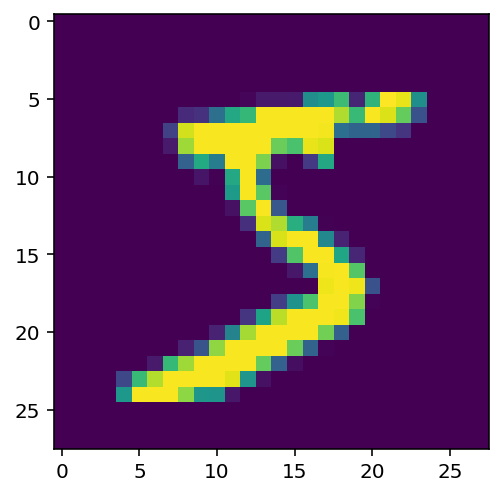

In [26]:
plt.imshow(i.squeeze().numpy())

In [27]:
image = np.array(i.numpy(), dtype=np.float32)

In [28]:
# Usando SageMaker Runtime para inferências
runtime = boto3.client('sagemaker-runtime')
print('endpoint name:', predictor.endpoint)

endpoint name: sagemaker-pytorch-2020-07-26-01-55-34-120


In [29]:
from io import BytesIO

#Serialise numpy ndarray as bytes
buffer = BytesIO()
# Assuming testX is a data frame
np.save(buffer, image)

response = runtime.invoke_endpoint(
    EndpointName=predictor.endpoint,
    Body=buffer.getvalue(),
    ContentType='application/x-npy',
    Accept='application/x-npy')

prediction = response['Body'].read()
stream = BytesIO(prediction)
prediction = np.load(stream, allow_pickle=True)

print(prediction.argmax(axis=1)[0])

5


### Cleanup

In [30]:
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: sagemaker-pytorch-2020-07-26-01-55-34-120
INFO:sagemaker:Deleting endpoint with name: sagemaker-pytorch-2020-07-26-01-55-34-120


<a id='pipeline'/>

## 2. Step Functions Pipeline

In [1]:
import sys

In [2]:
!{sys.executable} -m pip install --upgrade stepfunctions

Requirement already up-to-date: stepfunctions in /home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages (1.1.0)
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p36/bin/python -m pip install --upgrade pip' command.


In [3]:
import uuid
import time
import logging
from IPython import display
import stepfunctions
import boto3
import sagemaker

from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker import get_execution_role
from sagemaker import s3_input
from sagemaker.s3 import S3Uploader
from stepfunctions import steps
from stepfunctions.steps import TrainingStep, ModelStep
from stepfunctions.inputs import ExecutionInput
from stepfunctions.workflow import Workflow

In [4]:
session = sagemaker.Session()
stepfunctions.set_stream_logger(level=logging.INFO)

region = boto3.Session().region_name
sm_arn = get_execution_role()
id = uuid.uuid4().hex

# Não irei adicionar etapa de ETL com Glue para simplificar
# glue_job_name = 'glue-etl-{}'.format(id)

#Create a unique name for the AWS Lambda function to be created. If you change
#the default name, you may need to change the Step Functions execution role.
function_name = 'query-training-status-{}'.format(id)

In [5]:
print('Notebook instance Role ARN:', sm_arn)
stack_name='ml-pipeline-config'
print('Stack Name:', stack_name)

Notebook instance Role ARN: arn:aws:iam::725879053979:role/MLOps
Stack Name: ml-pipeline-config


Template do CloudFormation para simplificar criação de políticas no IAM, roles IAM, etc.:

In [6]:
# !aws cloudformation create-stack --stack-name {stack_name} --template-body file://cfns/cfn-config-ml-pipeline.json --parameters ParameterKey=NotebookRoleArn,ParameterValue={sm_arn} --capabilities CAPABILITY_NAMED_IAM
# !aws cloudformation wait stack-create-complete --stack-name {stack_name}

In [7]:
# Let's save Cfn output variables to make it easier
bucket = !aws cloudformation describe-stacks --stack-name {stack_name} --query "Stacks[0].Outputs[?OutputKey=='S3PipelineBucket'].OutputValue" --output text; 
bucket = bucket.s

step_functions_role_arn = !aws cloudformation describe-stacks --stack-name {stack_name} --query "Stacks[0].Outputs[?OutputKey=='StepFunctionsRoleArn'].OutputValue" --output text; 
step_functions_role_arn = step_functions_role_arn.s

# Não irei adicionar etapa de ETL com Glue para simplificar
# glue_role_arn = !aws cloudformation describe-stacks --stack-name {stack_name} --query "Stacks[0].Outputs[?OutputKey=='GlueRoleArn'].OutputValue" --output text; 
# glue_role_arn = glue_role_arn.s

lambda_role_arn = !aws cloudformation describe-stacks --stack-name {stack_name} --query "Stacks[0].Outputs[?OutputKey=='LambdaRoleArn'].OutputValue" --output text; 
lambda_role_arn = lambda_role_arn.s


In [8]:
print("Bucket Name:", bucket)
print("step_functions_role_arn:", step_functions_role_arn)
# print("glue_role_arn:",glue_role_arn)
print("lambda_role_arn:",lambda_role_arn)

Bucket Name: ml-pipeline-725879053979
step_functions_role_arn: arn:aws:iam::725879053979:role/StepFunctions_DSSDK-725879053979
lambda_role_arn: arn:aws:iam::725879053979:role/query_training_status-role-725879053979


In [9]:
training_job_name = f'pth-pipeline-{id}'
artifact_bucket = 's3://'+bucket
model_name = f'MNIST-{id}'
endpoint_name = 'PyTorchPipeline'
update_endpoint = False

print('INPUT CONFIGURATIONS:\n')
print('TrainingJobName (each Sagemaker Job requires a unique number):\n',training_job_name)
print('\nArtifact Bucket:\n',artifact_bucket)
print('\nModelName (each SageMaker Model requires a unique name):\n', model_name)
print('\nEndpointName (each Endpoint requires a unique name):\n', endpoint_name)
print('\nLambdaFunctionName:\n', endpoint_name)
print('\nUpdateEndpoint:', update_endpoint)

INPUT CONFIGURATIONS:

TrainingJobName (each Sagemaker Job requires a unique number):
 pth-pipeline-a690a0cb540c4f29b6c34ecaf808df81

Artifact Bucket:
 s3://ml-pipeline-725879053979

ModelName (each SageMaker Model requires a unique name):
 MNIST-a690a0cb540c4f29b6c34ecaf808df81

EndpointName (each Endpoint requires a unique name):
 PyTorchPipeline

LambdaFunctionName:
 PyTorchPipeline

UpdateEndpoint: False


In [10]:
project_name = 'pytorch'
code_path = 's3://{}/{}/code'.format(bucket, project_name)
print('code_path:', code_path)

code_path: s3://ml-pipeline-725879053979/pytorch/code


**Criação de  função AWS Lambda para validar performance de modelo**

In [11]:
import zipfile
zip_name = 'query_training_status.zip'
lambda_source_code = './code/query_training_status.py'

zf = zipfile.ZipFile(zip_name, mode='w')
zf.write(lambda_source_code, arcname=lambda_source_code.split('/')[-1])
zf.close()

S3Uploader.upload(local_path=zip_name, 
                  desired_s3_uri=code_path,
                  session=session)

's3://ml-pipeline-725879053979/pytorch/code/query_training_status.zip'

In [12]:
lambda_client = boto3.client('lambda')

response = lambda_client.create_function(
    FunctionName=function_name,
    Runtime='python3.7',
    Role=lambda_role_arn,
    Handler='query_training_status.lambda_handler',
    Code={
        'S3Bucket': bucket,
        'S3Key': '{}/code/{}'.format(project_name, zip_name)
    },
    Description='Queries a SageMaker training job and return the results.',
    Timeout=15,
    MemorySize=128
)

In [13]:
response

{'ResponseMetadata': {'RequestId': '4cf81a5c-e6c8-40a1-b402-9a4574debc94',
  'HTTPStatusCode': 201,
  'HTTPHeaders': {'date': 'Sun, 02 Aug 2020 00:30:50 GMT',
   'content-type': 'application/json',
   'content-length': '1019',
   'connection': 'keep-alive',
   'x-amzn-requestid': '4cf81a5c-e6c8-40a1-b402-9a4574debc94'},
  'RetryAttempts': 0},
 'FunctionName': 'query-training-status-a690a0cb540c4f29b6c34ecaf808df81',
 'FunctionArn': 'arn:aws:lambda:us-east-1:725879053979:function:query-training-status-a690a0cb540c4f29b6c34ecaf808df81',
 'Runtime': 'python3.7',
 'Role': 'arn:aws:iam::725879053979:role/query_training_status-role-725879053979',
 'Handler': 'query_training_status.lambda_handler',
 'CodeSize': 1580,
 'Description': 'Queries a SageMaker training job and return the results.',
 'Timeout': 15,
 'MemorySize': 128,
 'LastModified': '2020-08-02T00:30:50.299+0000',
 'CodeSha256': '5dE/nOuIoNdVeXZysgsTlaPLmvbCj153G3FFJqQ59WA=',
 'Version': '$LATEST',
 'TracingConfig': {'Mode': 'PassT

**Configuração de SageMaker Estimator**

In [14]:
from sagemaker.pytorch import PyTorch, PyTorchModel

In [15]:
cnn_training_job_name = 'framework-script-local-1596156081'
default_bucket = sagemaker.Session().default_bucket()
s3_script = f's3://{default_bucket}/{cnn_training_job_name}/source/sourcedir.tar.gz'
print('s3_script', s3_script)

s3_script s3://sagemaker-us-east-1-725879053979/framework-script-local-1596156081/source/sourcedir.tar.gz


In [16]:
artifact_bucket

's3://ml-pipeline-725879053979'

In [17]:
pth = PyTorch(
        entry_point='./mnist.py',
        source_dir=s3_script,
        role=sm_arn,
#         sagemaker_session=sagemaker.Session(sagemaker_client=sm),
        framework_version='1.1.0',
        train_instance_count=1,
        train_instance_type='ml.c4.xlarge',
#         hyperparameters={
#             'epochs': 1,
#             'backend': 'gloo',
#             'hidden_channels': 10,
#             'dropout': 0.2,
#             'kernel_size': 5,
#             'optimizer': 'sgd'
#         },
        metric_definitions=[
            {'Name':'train:loss', 'Regex':'\[Train Loss (.*?)\]'},
            {'Name':'test:loss', 'Regex':'\[Test Average loss (.*?)\]'},
            {'Name':'test:accuracy', 'Regex':'\[Test Accuracy (.*?)\]'}
        ],
        enable_sagemaker_metrics=True,
        output_path=artifact_bucket
    )    

**Criando pipeline de ML**

In [18]:
# SageMaker expects unique names for each job, model and endpoint. 
# If these names are not unique the execution will fail.
execution_input = ExecutionInput(schema={
    'TrainingJobName': str,
    'ModelName': str,
    'EndpointName': str,
    'LambdaFunctionName': str,
    'UpdateEndpoint': bool,
})

In [19]:
# SageMaker Training Step 
training_step = steps.TrainingStep(
    'Model Training', 
    estimator=pth,
    data={
        'training': 's3://sagemaker-experiments-us-east-1-725879053979/mnist'
    },
    hyperparameters={
            'epochs': '1',
            'backend': 'gloo',
            'hidden_channels': '10',
            'dropout': '0.2',
            'kernel_size': '5',
            'optimizer': 'sgd',
            'sagemaker_container_log_level': '20',
            'sagemaker_enable_cloudwatch_metrics': 'False',
            'sagemaker_program': 'mnist.py',
            'sagemaker_region': 'us-east-1',
            'sagemaker_submit_directory': 's3://sagemaker-us-east-1-725879053979/framework-script-local-1596156081/source/sourcedir.tar.gz'
        },
    job_name=execution_input['TrainingJobName'],
    wait_for_completion=True,
#     result_path='$.TrainingStepResults'
)

In [20]:
# Por padrão é criada "pasta" no S3 com nome do training job (o que no pipeline muda a cada caso)

# https://github.com/aws/sagemaker-python-sdk/blob/e774fcf37e943bb91f9c2668019f20f0f325c6da/src/sagemaker/estimator.py#L1756
# def _stage_user_code_in_s3(self):
#         """Upload the user training script to s3 and return the location.
#         Returns: s3 uri
#         """
#         local_mode = self.output_path.startswith("file://")

#         if self.code_location is None and local_mode:
#             code_bucket = self.sagemaker_session.default_bucket()
#             code_s3_prefix = "{}/{}".format(self._current_job_name, "source")
#             kms_key = None
#         elif self.code_location is None:
#             code_bucket, _ = parse_s3_url(self.output_path)
#             code_s3_prefix = "{}/{}".format(self._current_job_name, "source")
# #1770            kms_key = self.output_kms_key

In [26]:
# Usando código específico para inferência já no S3
sess = boto3.Session()
sm = sess.client('sagemaker')

s3_inference_tar = 's3://sagemaker-us-east-1-725879053979/sagemaker-pytorch-2020-07-31-00-51-18-859/sourcedir.tar.gz'

pth_model = PyTorchModel(model_data='$.TrainingStepResults.ModelArtifacts.S3ModelArtifacts',#artifact_bucket+'/'+training_job_name+'/output/model.tar.gz', 
                         role=sm_arn,
                         entry_point='inference.py', 
                         source_dir=s3_inference_tar,
                         framework_version='1.1.0',
                         sagemaker_session=sagemaker.Session(sagemaker_client=sm)
                        )

**Possibilidade 1 de utilização do PyTorchModel - mudar 2 linhas no SDK**

Step Functions SDK modificado (adicionei **\**kargs**):

https://github.com/aws/aws-step-functions-data-science-sdk-python/blob/2a104d3616ad1b8635409db9df71b153ad83f26b/src/stepfunctions/steps/sagemaker.py#L94

```
---> def get_expected_model(self, model_name=None, **kargs):
        """
            Build Sagemaker model representation of the expected trained model from the Training step. This can be passed
            to the ModelStep to save the trained model in Sagemaker.
            Args:
                model_name (str, optional): Specify a model name. If not provided, training job name will be used as the m$
            Returns:
                sagemaker.model.Model: Sagemaker model representation of the expected trained model.
        """
--->    model = self.estimator.create_model(**kargs)
        if model_name:
            model.name = model_name
        else:
            model.name = self.job_name
        model.model_data = self.output()["ModelArtifacts"]["S3ModelArtifacts"]
        return model
```

Obs.: Vou abrir uma issue no SDK e ver se modificam para abstrair melhor e possibilitar o uso de Frameworks mais facilmente

Feito isso, no ModelStep passar configurações na entrada para criação de modelo:
```
# SageMaker Model Step
model_step = steps.ModelStep(
    'Save Model',
    model=training_step.get_expected_model(entry_point='inference.py', 
                                         source_dir=s3_inference_tar),
    #pth_model,#'$.TrainingStepResults.ModelArtifacts.S3ModelArtifacts',
    instance_type='ml.t2.medium',
    model_name=execution_input['ModelName'],
    result_path='$.ModelStepResults'
)
```

**Possibilidade 2 de utilização do PyTorchModel - após criação, modificar diretamente na definição da máquina de estados do Step Functions**

Podemos simplementes gerar a máquina de estados pelo SDK e modificamos alguns detalhes.
Para pegar a máquina de estados, só fazer `workflow.definition.to_dict()`.

Assim usaríamos o Step Functions diretamente sem o Data Science SDK, deixando as coisas mais flexiveis.

https://docs.aws.amazon.com/step-functions/latest/dg/connect-sagemaker.html

Observar no estado Save Model (coloquei `----->` no JSON abaixo para facilitar):

`-----> 'ModelDataUrl.$': "$['ModelArtifacts']['S3ModelArtifacts']"},`

Mais detalhes de como o Step Functions processa entradas e saídas de cada estado:

https://docs.aws.amazon.com/step-functions/latest/dg/concepts-input-output-filtering.html

Isso indica para o Step Functions que devemos buscar no que o estado TrainingStep retornou e encontrar o local do tar.gz com o modelo PyTorch treinado:

        ```
        {'StartAt': 'Model Training',
         'States': {'Model Training': {'Resource': 'arn:aws:states:::sagemaker:createTrainingJob.sync',
           'Parameters': {'AlgorithmSpecification': {'TrainingImage': '520713654638.dkr.ecr.us-east-1.amazonaws.com/sagemaker-pytorch:1.1.0-cpu-py3',
             'TrainingInputMode': 'File',
             'MetricDefinitions': [{'Name': 'train:loss',
               'Regex': '\\[Train Loss (.*?)\\]'},
              {'Name': 'test:loss', 'Regex': '\\[Test Average loss (.*?)\\]'},
              {'Name': 'test:accuracy', 'Regex': '\\[Test Accuracy (.*?)\\]'}]},
            'OutputDataConfig': {'S3OutputPath': 's3://ml-pipeline-725879053979'},
            'StoppingCondition': {'MaxRuntimeInSeconds': 86400},
            'ResourceConfig': {'InstanceCount': 1,
             'InstanceType': 'ml.c4.xlarge',
             'VolumeSizeInGB': 30},
            'RoleArn': 'arn:aws:iam::725879053979:role/MLOps',
            'InputDataConfig': [{'DataSource': {'S3DataSource': {'S3DataType': 'S3Prefix',
                'S3Uri': 's3://sagemaker-experiments-us-east-1-725879053979/mnist',
                'S3DataDistributionType': 'FullyReplicated'}},
              'ChannelName': 'training'}],
            'HyperParameters': {'epochs': '1',
             'backend': 'gloo',
             'hidden_channels': '10',
             'dropout': '0.2',
             'kernel_size': '5',
             'optimizer': 'sgd',
             'sagemaker_container_log_level': '20',
             'sagemaker_enable_cloudwatch_metrics': 'False',
             'sagemaker_program': 'mnist.py',
             'sagemaker_region': 'us-east-1',
             'sagemaker_submit_directory': 's3://sagemaker-us-east-1-725879053979/framework-script-local-1596156081/source/sourcedir.tar.gz'},
            'TrainingJobName.$': "$$.Execution.Input['TrainingJobName']",
            'DebugHookConfig': {'S3OutputPath': 's3://ml-pipeline-725879053979'}},
           'Type': 'Task',
           'Next': 'Save Model'},
          'Save Model': {'ResultPath': '$.ModelStepResults',
           'Parameters': {'ModelName.$': "$$.Execution.Input['ModelName']",
            'PrimaryContainer': {'Image': '520713654638.dkr.ecr.us-east-1.amazonaws.com/sagemaker-pytorch:1.1.0-cpu-py3',
             'Environment': {'SAGEMAKER_PROGRAM': 'inference.py',
              'SAGEMAKER_SUBMIT_DIRECTORY': 's3://sagemaker-us-east-1-725879053979/sagemaker-pytorch-2020-07-31-00-51-18-859/sourcedir.tar.gz',
              'SAGEMAKER_ENABLE_CLOUDWATCH_METRICS': 'false',
              'SAGEMAKER_CONTAINER_LOG_LEVEL': '20',
              'SAGEMAKER_REGION': 'us-east-1'},
----------> 'ModelDataUrl.$': "$['ModelArtifacts']['S3ModelArtifacts']"},
            'ExecutionRoleArn': 'arn:aws:iam::725879053979:role/MLOps'},
           'Resource': 'arn:aws:states:::sagemaker:createModel',
           'Type': 'Task',
           'Next': 'Query Training Results'},
          'Query Training Results': {'Parameters': {'FunctionName.$': "$$.Execution.Input['LambdaFunctionName']",
            'Payload': {'TrainingJobName.$': '$.TrainingJobName'}},
           'Resource': 'arn:aws:states:::lambda:invoke',
           'Type': 'Task',
           'Next': 'Accuracy > 50%'},
          'Accuracy > 50%': {'Type': 'Choice',
           'Choices': [{'Variable': "$['Payload']['trainingMetrics'][0]['Value']",
             'NumericLessThan': 0.5,
             'Next': 'Create Model Endpoint Config'}],
           'Default': 'Model Accuracy Too Low'},
          'Model Accuracy Too Low': {'Comment': 'Validation accuracy lower than threshold',
           'Type': 'Fail'},
          'Create Model Endpoint Config': {'Resource': 'arn:aws:states:::sagemaker:createEndpointConfig',
           'Parameters': {'EndpointConfigName.$': "$$.Execution.Input['ModelName']",
            'ProductionVariants': [{'InitialInstanceCount': 1,
              'InstanceType': 'ml.m4.xlarge',
              'ModelName.$': "$$.Execution.Input['ModelName']",
              'VariantName': 'pthVariant'}],
            'DataCaptureConfig': {'EnableCapture': True,
             'InitialSamplingPercentage': 100,
             'DestinationS3Uri': 's3://sagemaker-experiments-us-east-1-725879053979/mnist/endpoint_monitoring/',
             'CaptureOptions': [{'CaptureMode': 'Input'}, {'CaptureMode': 'Output'}],
             'CaptureContentTypeHeader': {'CsvContentTypes': ['text/csv'],
              'JsonContentTypes': ['application/json']}}},
           'Type': 'Task',
           'Next': 'Update Model Endpoint'},
          'Update Model Endpoint': {'Resource': 'arn:aws:states:::sagemaker:createEndpoint',
           'Parameters': {'EndpointConfigName.$': "$$.Execution.Input['ModelName']",
            'EndpointName.$': "$$.Execution.Input['EndpointName']"},
           'Type': 'Task',
           'End': True}}}
        ```

In [28]:
# SageMaker Model Step
model_step = steps.ModelStep(
    'Save Model',
    model=training_step.get_expected_model(entry_point='inference.py', 
                                         source_dir=s3_inference_tar),
    #pth_model,#'$.TrainingStepResults.ModelArtifacts.S3ModelArtifacts',
    instance_type='ml.t2.medium',
    model_name=execution_input['ModelName'],
    result_path='$.ModelStepResults'
)

In [29]:
# Lambda Step - avaliação
lambda_step = steps.compute.LambdaStep(
    'Query Training Results',
    parameters={  
        "FunctionName": execution_input['LambdaFunctionName'],
        'Payload':{
            "TrainingJobName.$": '$.TrainingJobName'
        }
    }
)

In [30]:
# Choice Step - requerimento de performance de modelo
check_accuracy_step = steps.states.Choice(
    'Accuracy > 50%'
)

In [31]:
# SageMaker Endpoint Configuration Step - adicionando config de Model Monitor
data_capture_configuration = sagemaker.model_monitor.data_capture_config.DataCaptureConfig(
    enable_capture=True, 
    sampling_percentage=100, 
    destination_s3_uri='s3://sagemaker-experiments-us-east-1-725879053979/mnist/endpoint_monitoring/'
#     sagemaker_session=session
)

In [32]:
endpoint_config_step = steps.EndpointConfigStep(
    "Create Model Endpoint Config",
    endpoint_config_name=execution_input['ModelName'],
    model_name=execution_input['ModelName'],
    initial_instance_count=1,
    variant_name='pthVariant',
    instance_type='ml.m4.xlarge',
    data_capture_config=data_capture_configuration
)

In [33]:
# SageMaker Endpoint Step - criação de Endpoint com modelo treinado
endpoint_step = steps.EndpointStep(
    'Update Model Endpoint',
    endpoint_name=execution_input['EndpointName'],
    endpoint_config_name=execution_input['ModelName'],
#     update=execution_input['UpdateEndpoint']
)

In [34]:
# Fail Step
fail_step = steps.states.Fail(
    'Model Accuracy Too Low',
    comment='Validation accuracy lower than threshold'
)

In [35]:
# Configuração de regra de requerimento de performance de modelo
threshold_rule = steps.choice_rule.ChoiceRule.NumericLessThan(variable=lambda_step.output()['Payload']['trainingMetrics'][0]['Value'], value=.5)

check_accuracy_step.add_choice(rule=threshold_rule, next_step=endpoint_config_step)
check_accuracy_step.default_choice(next_step=fail_step)

In [36]:
# Juntando Steps
endpoint_config_step.next(endpoint_step)

workflow_definition = steps.Chain([
    training_step,
    model_step,
    lambda_step,
    check_accuracy_step
])

**Executando Workflow**

In [37]:
pipeline_name = f'Demo-PyTorch-Pipeline-{id}'

In [38]:
workflow = Workflow(
    name=pipeline_name,
    definition=workflow_definition,
    role=step_functions_role_arn,
    execution_input=execution_input
)

# For using existing workflow
# workflow = Workflow.list_workflows(); wkflws
# workflow = Workflow.attach(workflow[0]['stateMachineArn']); wkflw

In [39]:
workflow.definition.to_dict()

{'StartAt': 'Model Training',
 'States': {'Model Training': {'Resource': 'arn:aws:states:::sagemaker:createTrainingJob.sync',
   'Parameters': {'AlgorithmSpecification': {'TrainingImage': '520713654638.dkr.ecr.us-east-1.amazonaws.com/sagemaker-pytorch:1.1.0-cpu-py3',
     'TrainingInputMode': 'File',
     'MetricDefinitions': [{'Name': 'train:loss',
       'Regex': '\\[Train Loss (.*?)\\]'},
      {'Name': 'test:loss', 'Regex': '\\[Test Average loss (.*?)\\]'},
      {'Name': 'test:accuracy', 'Regex': '\\[Test Accuracy (.*?)\\]'}]},
    'OutputDataConfig': {'S3OutputPath': 's3://ml-pipeline-725879053979'},
    'StoppingCondition': {'MaxRuntimeInSeconds': 86400},
    'ResourceConfig': {'InstanceCount': 1,
     'InstanceType': 'ml.c4.xlarge',
     'VolumeSizeInGB': 30},
    'RoleArn': 'arn:aws:iam::725879053979:role/MLOps',
    'InputDataConfig': [{'DataSource': {'S3DataSource': {'S3DataType': 'S3Prefix',
        'S3Uri': 's3://sagemaker-experiments-us-east-1-725879053979/mnist',
       

In [40]:
workflow.render_graph(portrait=True)

**Exportando CloudFormation (caso desejado)**

In [41]:
print(workflow.get_cloudformation_template())

[WARNING] To reuse the CloudFormation template in different regions, please make sure to update the region specific AWS resources in the StateMachine definition.
AWSTemplateFormatVersion: '2010-09-09'
Description: CloudFormation template for AWS Step Functions - State Machine
Resources:
  StateMachineComponent:
    Type: AWS::StepFunctions::StateMachine
    Properties:
      StateMachineName: Demo-PyTorch-Pipeline-a690a0cb540c4f29b6c34ecaf808df81
      DefinitionString: |-
        {
          "StartAt": "Model Training",
          "States": {
            "Model Training": {
              "Resource": "arn:aws:states:::sagemaker:createTrainingJob.sync",
              "Parameters": {
                "AlgorithmSpecification": {
                  "TrainingImage": "520713654638.dkr.ecr.us-east-1.amazonaws.com/sagemaker-pytorch:1.1.0-cpu-py3",
                  "TrainingInputMode": "File",
                  "MetricDefinitions": [
                    {
                      "Name": "train:loss

**Criando workflow**

In [42]:
workflow.create()

[INFO] Workflow created successfully on AWS Step Functions.


'arn:aws:states:us-east-1:725879053979:stateMachine:Demo-PyTorch-Pipeline-a690a0cb540c4f29b6c34ecaf808df81'

In [43]:
workflow

Workflow(name='Demo-PyTorch-Pipeline-a690a0cb540c4f29b6c34ecaf808df81', role='arn:aws:iam::725879053979:role/StepFunctions_DSSDK-725879053979', state_machine_arn='arn:aws:states:us-east-1:725879053979:stateMachine:Demo-PyTorch-Pipeline-a690a0cb540c4f29b6c34ecaf808df81')

Let's see the state machines in the current region in this AWS account:

In [44]:
Workflow.list_workflows(html=True)

Name,Creation Date
Demo-ML-Pipeline-beb8008a875a479ab6842ba94f371abc,"Jun 18, 2020 07:30:57.115 PM"
Demo-ML-Pipeline-beb8008a875a479ab6842ba94f371abc3,"Jun 18, 2020 08:10:53.896 PM"
Demo-PyTorch-Pipeline-939a36e424ab4794b533ab0041b3b9ef,"Aug 01, 2020 10:19:31.971 PM"
Demo-PyTorch-Pipeline-a690a0cb540c4f29b6c34ecaf808df81,"Aug 02, 2020 12:30:51.225 AM"
DevelopingWithStepFunctionsDotNetCore,"Jan 10, 2019 02:08:54.714 AM"
training-pipeline-2020-07-21-14-33-44,"Jul 21, 2020 02:36:34.835 PM"
training-pipeline-2020-07-31-01-21-03,"Jul 31, 2020 01:21:04.206 AM"


**Disparando Pipeline de ML**

In [45]:
print('INPUT CONFIGURATIONS:\n')
print('TrainingJobName (each Sagemaker Job requires a unique number):\n',training_job_name)
print('\nModelName (each SageMaker Model requires a unique name,):\n', model_name)
print('\nEndpointName (each Endpoint requires a unique name):\n', endpoint_name)
print('\nLambdaFunctionName:\n', endpoint_name)
print('UpdateEndpoint:', update_endpoint)

INPUT CONFIGURATIONS:

TrainingJobName (each Sagemaker Job requires a unique number):
 pth-pipeline-a690a0cb540c4f29b6c34ecaf808df81

ModelName (each SageMaker Model requires a unique name,):
 MNIST-a690a0cb540c4f29b6c34ecaf808df81

EndpointName (each Endpoint requires a unique name):
 PyTorchPipeline

LambdaFunctionName:
 PyTorchPipeline
UpdateEndpoint: False


In [46]:
execution = workflow.execute(
    inputs={
        'TrainingJobName': training_job_name,
        'ModelName': model_name,
        'EndpointName': endpoint_name,
        'LambdaFunctionName': function_name,
        'UpdateEndpoint': update_endpoint
    }
)

[INFO] Workflow execution started successfully on AWS Step Functions.


In [47]:
# If don't want to wait for the whole pipeline to finish, set to False
wait = True

In [48]:
# Just check current status if we don't want to check all flow
if not wait:
    execution.render_progress(portrait=True)

In [49]:
status = execution.describe().get('status')
while status == 'RUNNING' and wait:
    display.clear_output(wait=True)
    display.display(execution.render_progress(portrait=True))
    status = execution.describe().get('status')
    time.sleep(20)

In [50]:
display.display(execution.render_progress(portrait=True))

In [51]:
workflow.list_executions(html=True)

Name,Status,Started,End Time
d8652435-0e51-4156-9eef-9ef1f9d56032,SUCCEEDED,"Aug 02, 2020 12:30:51.382 AM","Aug 02, 2020 12:34:46.633 AM"


In [52]:
execution.list_events() #html=True

[{'timestamp': datetime.datetime(2020, 8, 2, 0, 30, 51, 382000, tzinfo=tzlocal()),
  'type': 'ExecutionStarted',
  'id': 1,
  'previousEventId': 0,
  'executionStartedEventDetails': {'input': '{\n    "TrainingJobName": "pth-pipeline-a690a0cb540c4f29b6c34ecaf808df81",\n    "ModelName": "MNIST-a690a0cb540c4f29b6c34ecaf808df81",\n    "EndpointName": "PyTorchPipeline",\n    "LambdaFunctionName": "query-training-status-a690a0cb540c4f29b6c34ecaf808df81",\n    "UpdateEndpoint": false\n}',
   'roleArn': 'arn:aws:iam::725879053979:role/StepFunctions_DSSDK-725879053979'}},
 {'timestamp': datetime.datetime(2020, 8, 2, 0, 30, 51, 415000, tzinfo=tzlocal()),
  'type': 'TaskStateEntered',
  'id': 2,
  'previousEventId': 0,
  'stateEnteredEventDetails': {'name': 'Model Training',
   'input': '{\n    "TrainingJobName": "pth-pipeline-a690a0cb540c4f29b6c34ecaf808df81",\n    "ModelName": "MNIST-a690a0cb540c4f29b6c34ecaf808df81",\n    "EndpointName": "PyTorchPipeline",\n    "LambdaFunctionName": "query-tra

In [53]:
import boto3
sm_client = boto3.client('sagemaker')

endpoint_status = 'Creating'
while endpoint_status!='InService':
    endpoint_status = sm_client.describe_endpoint(EndpointName=endpoint_name)['EndpointStatus']
    print(endpoint_status)
    time.sleep(10)

Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
InService


### Realizando inferências

Para desenvolvimento poderiamos usar apenas o `predictor.predict(my_payload)`, mas vamos usar o client do SageMaker Runtime (o que seria algo produtivo).


In [54]:
import torch
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [55]:
# download the dataset
# this will not only download data to ./mnist folder, but also load and transform (normalize) them
train_set = datasets.MNIST('mnist', train=True, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))]), 
    download=True)
                           
test_set = datasets.MNIST('mnist', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))]),
    download=False)

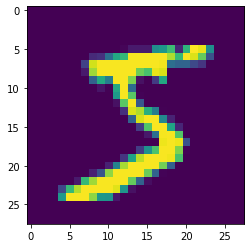

In [56]:
loader = iter(torch.utils.data.DataLoader(train_set))

i, l = next(loader)

plt.imshow(i.squeeze().numpy())

In [57]:
image = np.array(i.numpy(), dtype=np.float32)

In [58]:
# Usando SageMaker Runtime para inferências
runtime = boto3.client('sagemaker-runtime')
print('endpoint name:', endpoint_name)

endpoint name: PyTorchPipeline


In [59]:
from io import BytesIO

#Serialise numpy ndarray as bytes
buffer = BytesIO()
# Assuming testX is a data frame
np.save(buffer, image)

response = runtime.invoke_endpoint(
    EndpointName=endpoint_name,
    Body=buffer.getvalue(),
    ContentType='application/x-npy',
    Accept='application/x-npy')

prediction = response['Body'].read()
stream = BytesIO(prediction)
prediction = np.load(stream, allow_pickle=True)

print(prediction.argmax(axis=1)[0])

5


**Enviando tráfego artificial ao nosso endpoint**

In [60]:
from stress import stress_button

In [61]:
stress_button

Note that you need to stop the kernel to stop the invocations.

### See traffic metrics and data captured

In your `CustomerChurnMLPipeline` endpoint in SageMaker, select the S3 bucket where the data captured from requests and predictions are stored:

![sm_ep_data_capture](./imgs/sm_ep_data_capture.png)

We should see objects being saved in the S3 bucket:
![s3_data_capture](./imgs/s3_data_capture.png)

In your `CustomerChurnMLPipeline` endpoint in SageMaker, click on the `View invocation metrics` link. We will be redirected to the CloudWatch console:
![sm_cw_metrics](./imgs/sm_ep_metrics.png)

For CloudWatch, <a href="https://console.aws.amazon.com/cloudwatch/home?region=us-east-1#metricsV2:graph=~(metrics~(~(~'AWS*2fSageMaker~'Invocations~'EndpointName~'CustomerChurnMLPipeline~'VariantName~'xgbVariant))~view~'timeSeries~stacked~false~region~'us-east-1~start~'-PT5M~end~'P0D~stat~'Sum~period~60);query=~'*7bAWS*2fSageMaker*2cEndpointName*2cVariantName*7d*20CustomerChurnMLPipeline">just click here.</a>

OR

Configure the Dashboard by selecting the metric `Invocations` and in the `Graphics metrics` choose Invocations and `Sum` in `Statistic`. Choose `Period` equals to 1 Minute and modify graphics in the top to show the window of 5 minutes.

![sm_ep_metrics](./imgs/sm_cw_metrics.png)

### Cleanup

In [62]:
# # delete 
# workflow_training.delete()
# workflow_deploy.delete()

# # delete monitor
# # delete endpoint
# # delete endpoint config
# # delete model


# lambda_client.delete_function(function_name)

# !aws cloudformation delete-stack --stack-name {stack_name} --template-body file://cfns/cfn-config-ml-pipeline.json --parameters ParameterKey=NotebookRoleArn,ParameterValue={sm_arn} --capabilities CAPABILITY_NAMED_IAM
